# **1. Libraries**

In [ ]:
!pip install xgboost lightgbm wordcloud

In [ ]:
# Essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import re
import time

# Text and visualization
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Preprocessing and utilities
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from scipy.sparse import csr_matrix

# Models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# **2. Data Reading**

In [ ]:
import pandas as pd

# Login using e.g. `huggingface-cli login` to access this dataset
df = pd.read_csv("hf://datasets/natasyarev/dataset_trinity_minds/dataset_sephora.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
display(df.head())

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,True,online only,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,True,online only,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26,2600,180.0,180.0,...,True,online only,- 1oz/30mL Eau de Toilette - 2.5 oz/ 74 mL E...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23,2900,120.0,120.0,...,True,online only,- 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2,943,72.0,80.0,...,True,online only,no options,The Colonia Miniature Set comes in an iconic A...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0,0


In [ ]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (9168, 21)


In [ ]:
# Generate a summary of the dataset
def summary(df):
    summary = pd.DataFrame({})
    summary.index.name = 'Column name'
    summary['dtype'] = df.dtypes
    summary['num of nulls'] = df.isnull().sum()
    summary['null_percentage'] = round(df.isnull().mean()*100, 2)
    summary['num of unique values'] = df.nunique()
    summary['first_value'] = df.iloc[0]
    return summary.sort_values(by='null_percentage', ascending=False)
summary(df)

,dtype,num of nulls,null_percentage,num of unique values,first_value
Column name,,,,,
id,int64,0,0.0,9115,2218774
brand,object,0,0.0,324,Acqua Di Parma
category,object,0,0.0,143,Fragrance
name,object,0,0.0,9106,Blu Mediterraneo MINIATURE Set
size,object,0,0.0,1623,5 x 0.16oz/5mL
rating,float64,0,0.0,10,4.0
number_of_reviews,int64,0,0.0,833,4
love,int64,0,0.0,1683,3002
price,float64,0,0.0,286,66.0


# 4. **Preprocessing**
  
  4.1 Creating derived columns (discount and volume in mL)

In [ ]:
df['discount_percentage'] = ((df['price'] / df['value_price']) - 1) * 100

In [ ]:
# Function to extract mL, removing extra spaces
def extract_ml(text):
    clean_text = text.replace(" ", "")  # Removes spaces
    match = re.search(r'(\d+\.?\d*)mL', clean_text)  # Regex to find mL
    if match:
        return float(match.group(1))  # Returns the value in mL
    return None  # Returns None if no value is found

# Applying the function to the 'size' column to create the new 'mL_extraido' column
df['mL_extracted'] = df['size'].apply(extract_ml)

In [ ]:
df[['value_price','price','discount_percentage','size','mL_extracted']].head(10)

,value_price,price,discount_percentage,size,mL_extracted
0,75.0,66.0,-12.0,5 x 0.16oz/5mL,5.0
1,66.0,66.0,0.0,0.7 oz/ 20 mL,20.0
2,180.0,180.0,0.0,5 oz/ 148 mL,148.0
3,120.0,120.0,0.0,2.5 oz/ 74 mL,74.0
4,80.0,72.0,-10.0,5 x 0.16oz/5mL,5.0
5,180.0,180.0,0.0,5 oz/ 148 mL,148.0
6,210.0,210.0,0.0,3.4 oz/ 101 mL,101.0
7,120.0,120.0,0.0,1.7 oz/ 50 mL,50.0
8,58.0,58.0,0.0,1.7oz/50mL,50.0
9,58.0,58.0,0.0,1.7oz/50mL,50.0


In [ ]:
df[['value_price','price','discount_percentage','size','mL_extracted']].dtypes

,0
value_price,float64
price,float64
discount_percentage,float64
size,object
mL_extracted,float64


4.2 Dropping irrelevant column

In [ ]:
columns_to_drop = ['MarketingFlags_content', 'MarketingFlags', 'URL']
existing_columns = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=existing_columns)
df.columns

Index(['id', 'brand', 'category', 'name', 'size', 'rating',
       'number_of_reviews', 'love', 'price', 'value_price', 'options',
       'details', 'how_to_use', 'ingredients', 'online_only', 'exclusive',
       'limited_edition', 'limited_time_offer', 'discount_percentage',
       'mL_extracted'],
      dtype='object')

4.3 Dropping duplicates

In [ ]:
df.drop_duplicates(inplace = True)
df.duplicated().sum()

np.int64(0)

Kami menyertakan outlier dalam analisis ini karena outlier mencerminkan karakteristik utama pasar, yaitu rentang harga produk yang sangat beragam, termasuk produk-produk dengan harga sangat tinggi.

# **5. EDA**
5.1 Brand Distribuition¶

/tmp/ipython-input-16-2499386948.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


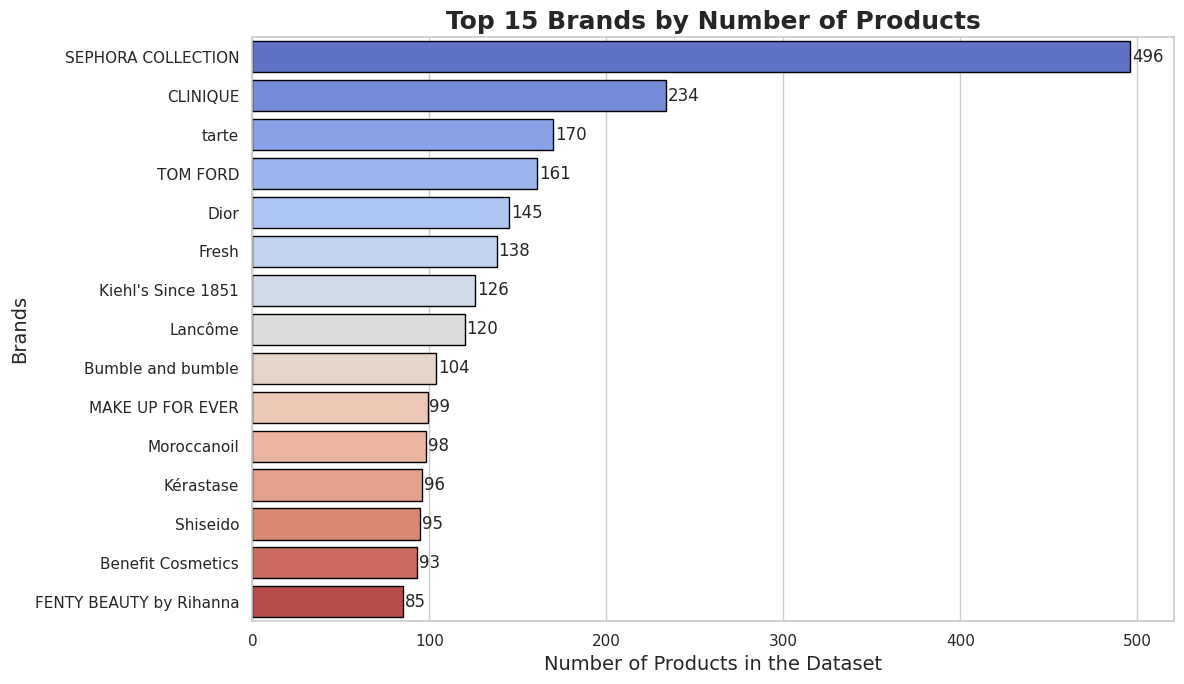

In [ ]:
# Count unique brands and select the top 15 most frequent
brand_counts = df['brand'].value_counts().head(15)

# Configure Seaborn style
sns.set_theme(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(
    x=brand_counts.values,
    y=brand_counts.index,
    palette="coolwarm",
    edgecolor="black"
)

# Add titles and labels
plt.title('Top 15 Brands by Number of Products', fontsize=18, weight='bold')
plt.xlabel('Number of Products in the Dataset', fontsize=14)
plt.ylabel('Brands', fontsize=14)

# Add values to the end of each bar
for i, value in enumerate(brand_counts.values):
    plt.text(value + 1, i, str(value), va='center', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

5.2 Price Distribuition

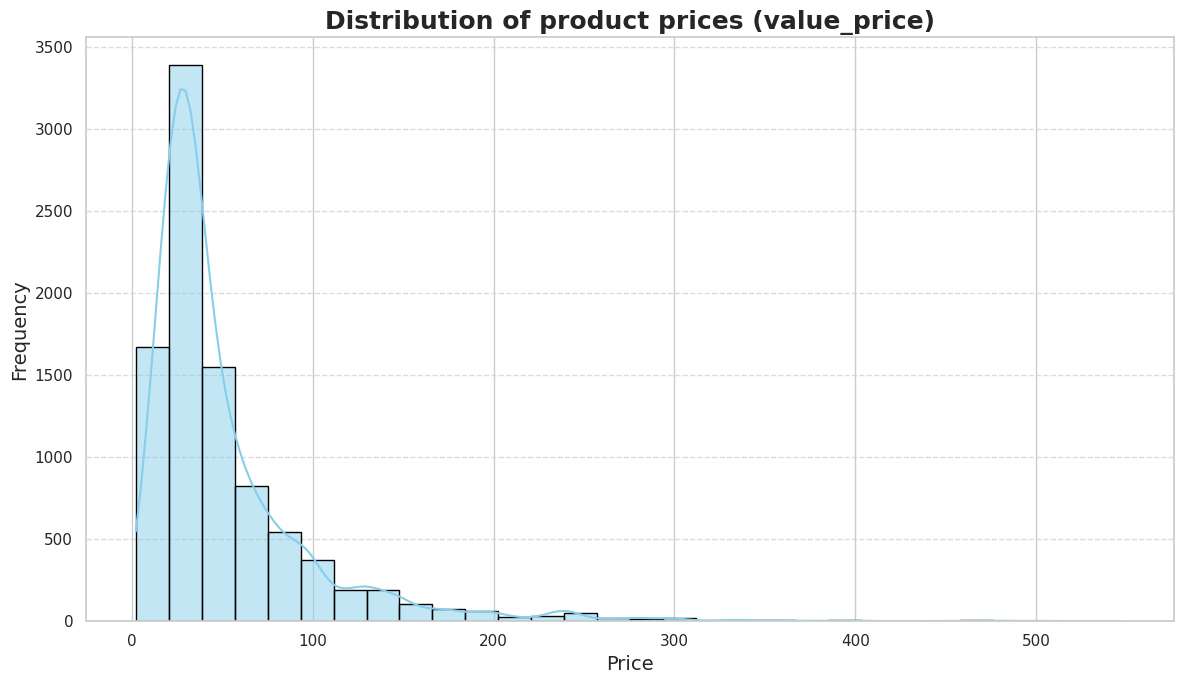

In [ ]:
# Configure Seaborn style
sns.set_theme(style="whitegrid")

# Plot the distribution of prices in the 'value_price' column
plt.figure(figsize=(12, 7))
sns.histplot(df['value_price'], bins=30, kde=True, color="skyblue", edgecolor="black")
plt.title('Distribution of product prices (value_price)', fontsize=18, weight='bold')
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

5.3 Most expensive brands

/tmp/ipython-input-18-3401832387.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


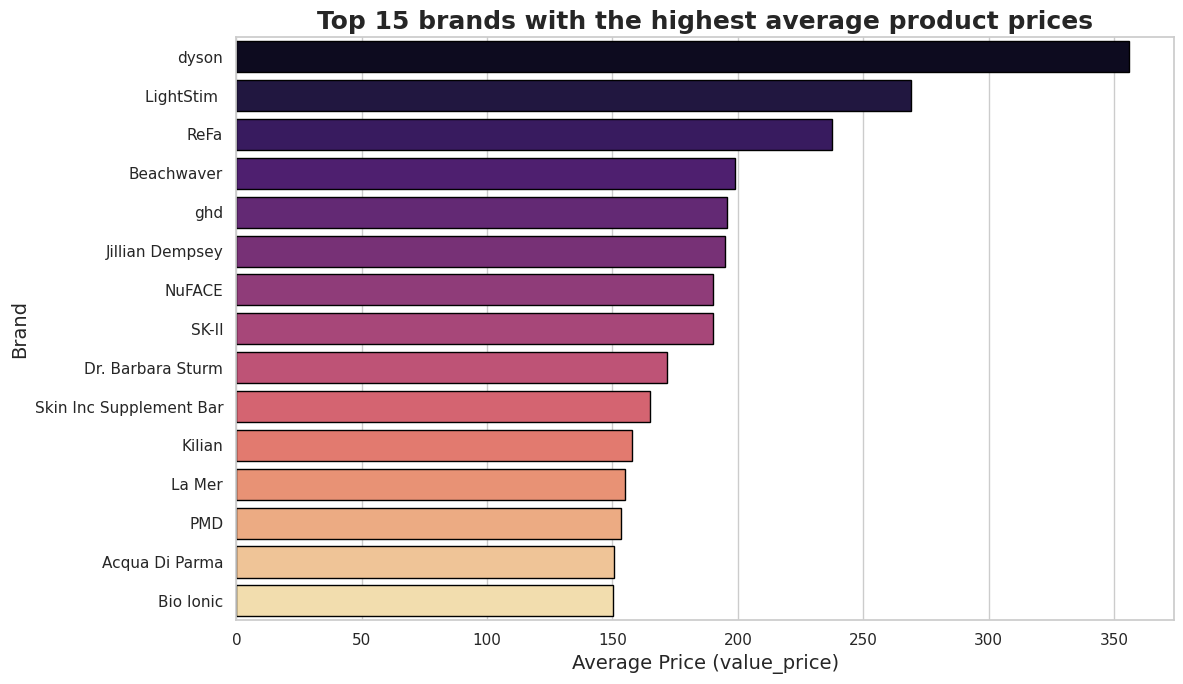

In [ ]:
# Calculate the average 'value_price' for each brand
avg_price_per_brand = df.groupby('brand')['value_price'].mean().sort_values(ascending=False).head(15)

# Set the plot style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 7))
sns.barplot(
    x=avg_price_per_brand.values,
    y=avg_price_per_brand.index,
    palette="magma",
    edgecolor="black"
)

# Add titles and labels
plt.title('Top 15 brands with the highest average product prices', fontsize=18, weight='bold')
plt.xlabel('Average Price (value_price)', fontsize=14)
plt.ylabel('Brand', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

5.4 Most expensive categories (and most expensive products)

/tmp/ipython-input-19-2141814447.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


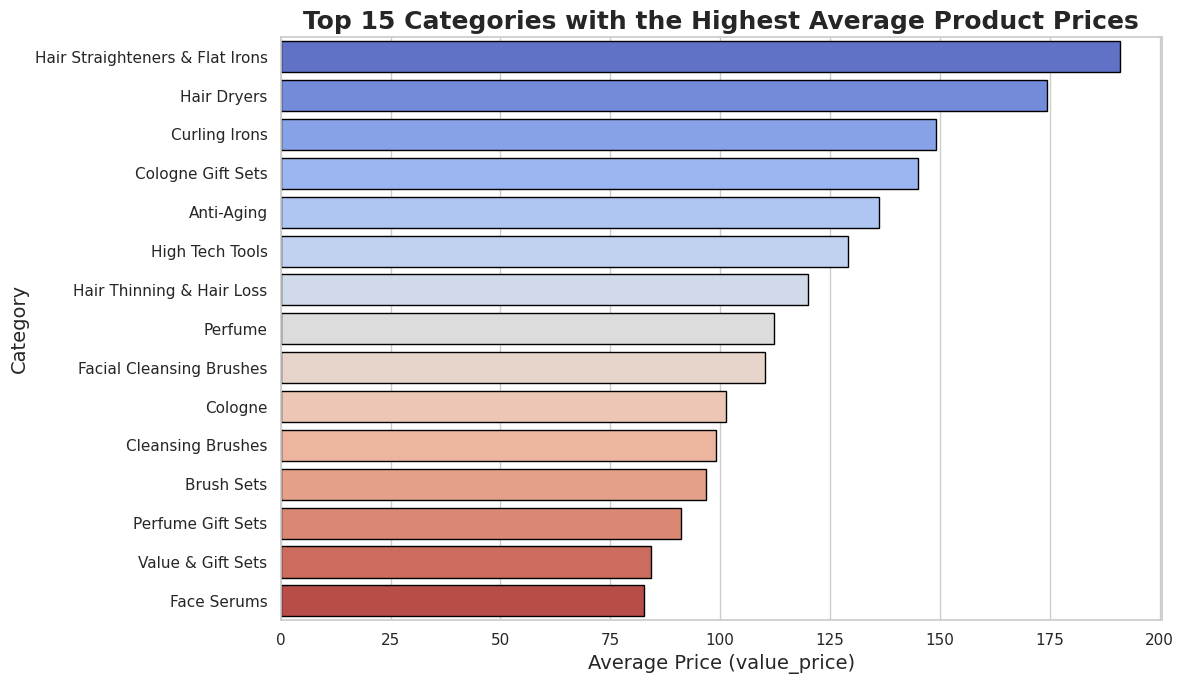

,name,brand,value_price
2589,Airwrap™ Styler,dyson,549.0
2437,SpectraLite™ Faceware Pro Wrinkle Reducing Duo,Dr. Dennis Gross Skincare,504.0
2590,Corrale™ Hair Straightener,dyson,499.0
6427,Neuropeptide Smoothing Facial Conformer,Perricone MD,495.0
444,Elite Mirror Ten Brush Set,Artis,483.0
6058,Trinity + Eye and Lip Enhancer Attachment Bundle,NuFACE,474.0
6064,Trinity Facial Toning Device + Wrinkle Reducer...,NuFACE,474.0
2592,Supersonic™ Hair Dryer Limited Edition Gift Set,dyson,465.0
2591,Supersonic™ Hair Dryer Gift Edition with Red Case,dyson,460.0
3396,Orchidée Impériale The Cream,Guerlain,460.0


In [ ]:
# Calculate the average 'value_price' for each category
avg_price_per_category = df.groupby('category')['value_price'].mean().sort_values(ascending=False).head(15)

# Set the plot style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 7))
sns.barplot(
    x=avg_price_per_category.values,
    y=avg_price_per_category.index,
    palette="coolwarm",
    edgecolor="black"
)

# Add titles and labels
plt.title('Top 15 Categories with the Highest Average Product Prices', fontsize=18, weight='bold')
plt.xlabel('Average Price (value_price)', fontsize=14)
plt.ylabel('Category', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# List the most expensive products
most_expensive_products = df[['name', 'brand', 'value_price']].sort_values(by='value_price', ascending=False).head(10)
most_expensive_products

5.5 Rating Distribution

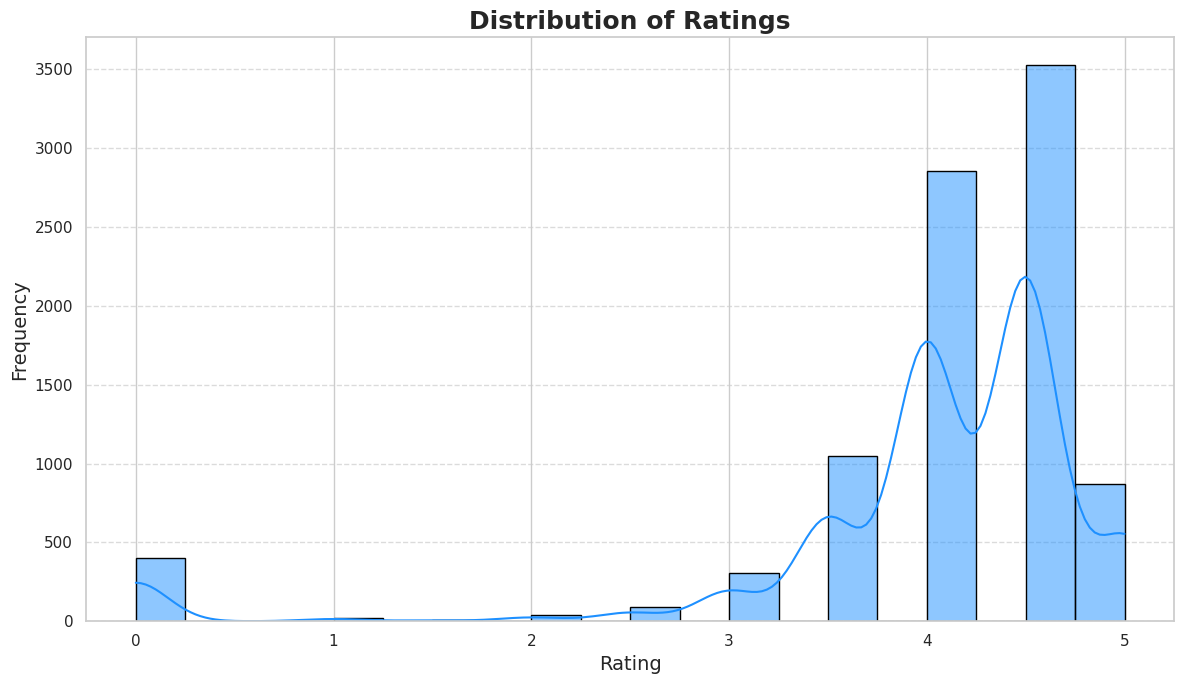

In [20]:
# Set the Seaborn style
sns.set_theme(style="whitegrid")

# Plot the distribution of the 'rating' column
plt.figure(figsize=(12, 7))
sns.histplot(df['rating'], bins=20, kde=True, color="dodgerblue", edgecolor="black")

# Add titles and labels
plt.title('Distribution of Ratings', fontsize=18, weight='bold')
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
df['rating'].value_counts()

,count
rating,
4.5,3527
4.0,2853
3.5,1051
5.0,872
0.0,398
3.0,308
2.5,88
2.0,39
1.0,23


5.6 Most frequent categories

In [21]:
# Count occurrences of each category
category_counts = df['category'].value_counts()

# Display the top 10 most frequent categories with better formatting
print("Top 10 most frequent categories in the dataset:\n")
print(category_counts.head(10).to_frame(name='Frequency'))

Top 10 most frequent categories in the dataset:

                           Frequency
category                            
Perfume                          665
Moisturizers                     451
Face Serums                      384
Value & Gift Sets                378
Face Wash & Cleansers            247
Face Masks                       230
Rollerballs & Travel Size        228
Hair Styling Products            224
Eye Palettes                     202
Lipstick                         191


5.7 Perfume category analysis

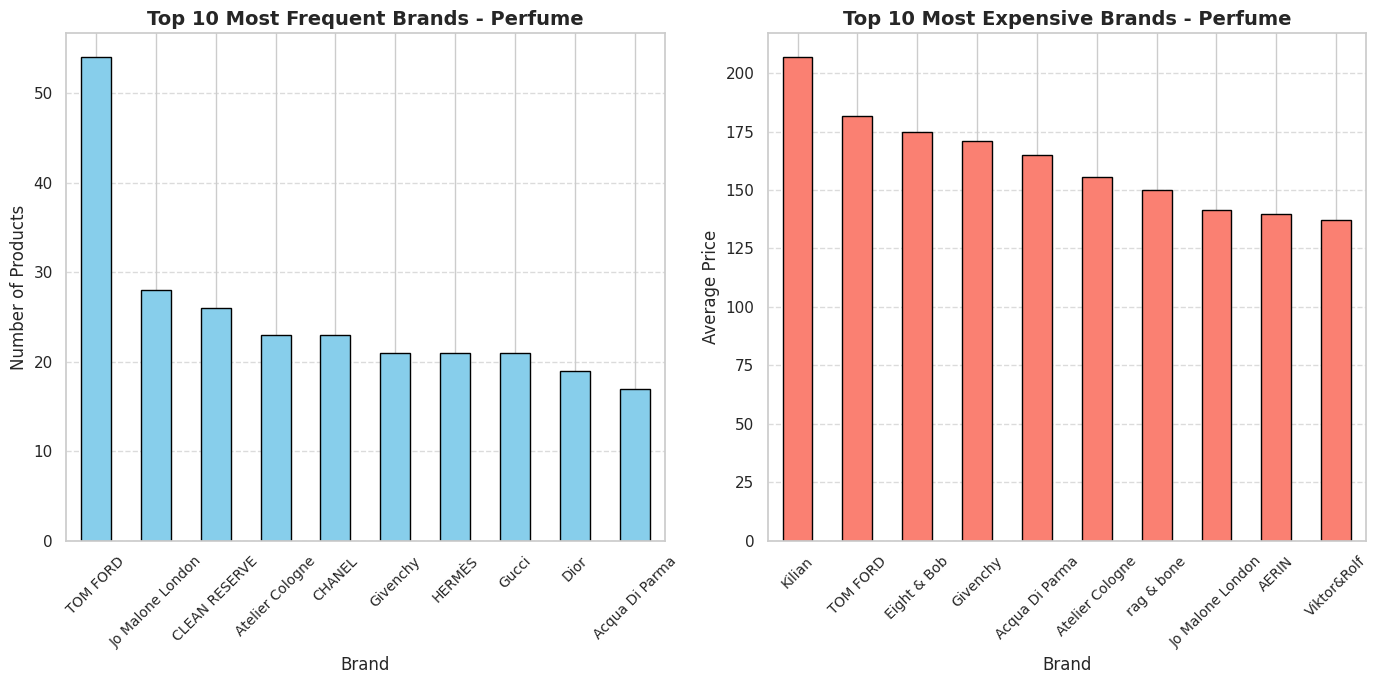

In [22]:
# Filter the data for the "Perfume" category
perfume_df = df[df['category'] == 'Perfume']

# Count the most frequent brands in the "Perfume" category
brand_counts = perfume_df['brand'].value_counts()

# Find the most expensive brands in the "Perfume" category (assuming "price" contains the values)
brand_avg_price = perfume_df.groupby('brand')['price'].mean().sort_values(ascending=False)

# Plot the most frequent brands
plt.figure(figsize=(14, 7))

# Subplot for top 10 most frequent brands
plt.subplot(1, 2, 1)
brand_counts.head(10).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Most Frequent Brands - Perfume', fontsize=14, weight='bold')
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Subplot for top 10 most expensive brands
plt.subplot(1, 2, 2)
brand_avg_price.head(10).plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Top 10 Most Expensive Brands - Perfume', fontsize=14, weight='bold')
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Catatan: Setelah bekerja selama beberapa tahun di industri kecantikan (termasuk parfum), kami merasa agak janggal melihat merek-merek mewah menjadi yang paling dominan dalam dataset ini. Hal ini mungkin disebabkan oleh ketersediaan merek-merek tersebut pada saat data diambil.

5.8 Text Vectorization and Frequency Analysis

In [23]:
def preprocess_text(text):
    """
    Preprocess text by converting it to lowercase and removing special characters.

    Parameters:
        text (str): The input text to be cleaned.

    Returns:
        str: The cleaned text.
    """
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters, keeping only letters, numbers, and spaces
    return text

# Apply the preprocessing function to the 'details' column
df['details_cleaned'] = df['details'].apply(preprocess_text)

In [24]:
# Create a CountVectorizer instance, removing common stop words (e.g., "the", "and")
vectorizer = CountVectorizer(stop_words='english')

# Transform the cleaned text data into a document-term matrix
X = vectorizer.fit_transform(df['details_cleaned'])

# Calculate word frequencies
word_freq = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)  # Sort by frequency in descending order

# Display the top 10 most frequent words
top_10_words = word_freq[:10]
print("Top 10 most frequent words:")
for word, freq in top_10_words:
    print(f"{word}: {freq}")

Top 10 most frequent words:
skin: 17591
know: 7505
need: 7331
ingredients: 7144
hair: 6731
product: 5920
oil: 5907
formulated: 5556
parabens: 5318
type: 5236


5.9 Claim Detection and Visualization




In [25]:
# Define a list of common claims/keywords to analyze in product descriptions
claims = [
    'free', 'natural', 'organic', 'fine lines', 'wrinkles', 'healthy',
    'cruelty free', 'sensitive skin', 'acne', 'aging', 'clinical',
    'revitalizing', 'age', 'botanical', 'instant', 'firming', 'results',
    'volumizing', 'growth', 'clinically tested', 'ethical'
]

# Count occurrences of each claim in the cleaned 'details_cleaned' column
claim_counts = {
    claim: df['details_cleaned'].str.contains(claim, case=False, na=False).sum()
    for claim in claims
}

# Convert the claim counts dictionary into a DataFrame for better visualization
claim_counts_df = (
    pd.DataFrame.from_dict(claim_counts, orient='index', columns=['count'])
    .sort_values(by='count', ascending=False)
)

# Display the resulting DataFrame
print("Claim frequencies in product details:")
print(claim_counts_df)

Claim frequencies in product details:
                   count
free                5206
age                 3695
natural             2919
aging               1880
results             1720
fine lines          1452
wrinkles            1348
clinical            1070
healthy             1061
instant              888
acne                 365
botanical            355
organic              284
sensitive skin       277
volumizing           178
firming              129
growth                85
revitalizing          79
clinically tested     67
cruelty free          38
ethical               20


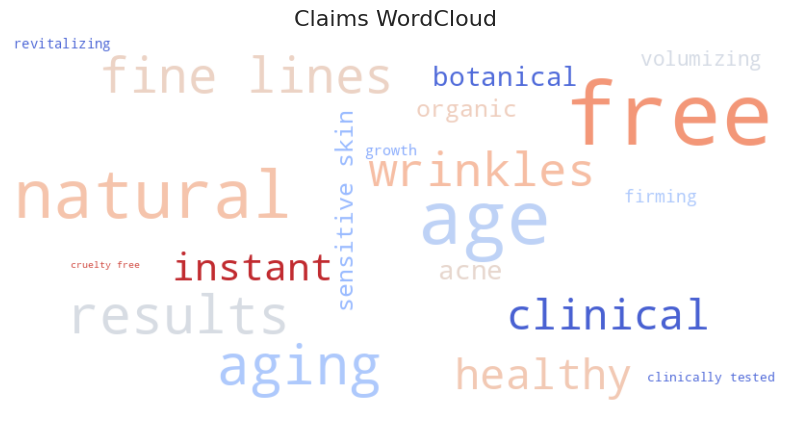

In [26]:
# Create a WordCloud object based on the claim frequencies
wordcloud = WordCloud(
    width=800,                 # Width of the canvas
    height=400,                # Height of the canvas
    background_color="white",  # Background color
    colormap="coolwarm",       # Color palette for the words
    max_font_size=90,          # Maximum font size for the words
    min_font_size=10,          # Minimum font size for the words
    max_words=50,              # Maximum number of words to display
    contour_width=1,           # Width of the contour around the WordCloud
    contour_color="black"      # Color of the contour
).generate_from_frequencies(claim_counts)

# Plot the WordCloud
plt.figure(figsize=(10, 5))         # Set the figure size
plt.imshow(wordcloud, interpolation="bilinear")  # Display the WordCloud with smooth rendering
plt.axis("off")                     # Hide axes for better aesthetics
plt.title("Claims WordCloud", fontsize=16)  # Add a title to the plot
plt.show()

# **6. Model Comparison and Selection**
6.1 Data Preprocessing and Model Training with Random Forest Regressor


In [27]:
# Select relevant columns
columns_to_keep = [
    'brand', 'category', 'size', 'number_of_reviews', 'love', 'price', 'value_price',
    'online_only', 'exclusive', 'limited_edition', 'limited_time_offer'
]
target = 'rating'  # Target variable

# Filter the DataFrame
df_filtered = df[columns_to_keep + [target]]

# Separate categorical and numerical columns
categorical_cols = ['brand', 'category', 'size']  # Categorical columns
numeric_cols = [col for col in columns_to_keep if col not in categorical_cols]  # Numerical columns

# Split features (X) and target variable (y)
X = df_filtered.drop(columns=target)  # Independent variables
y = df_filtered[target]               # Dependent variable

# Split data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create a preprocessor for categorical and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),                     # Pass numerical columns as-is
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical columns
    ]
)

# Build the pipeline for preprocessing and modeling
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))  # Random Forest Regressor
])

# Train the model and evaluate using cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"Mean R² from cross-validation: {scores.mean():.4f}")

# Measure training time
start_time = time.time()  # Start timer

# Train the pipeline on the training set
model.fit(X_train, y_train)

end_time = time.time()  # End timer

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)  # R² score on the test set

# Calculate Mean Squared Error (optional)
test_mse = mean_squared_error(y_test, y_test_pred)

# Calculate total training time
training_time = end_time - start_time

# Print results
print(f"R² score on test set: {test_r2:.4f}")
print(f"Mean Squared Error (MSE) on test set: {test_mse:.4f}")
print(f"Training time: {training_time:.2f} seconds")

Mean R² from cross-validation: 0.7267
R² score on test set: 0.7194
Mean Squared Error (MSE) on test set: 0.2854
Training time: 16.34 seconds


6.2 XGBoost Regressor

In [33]:
# Define the model with pipeline
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('regressor', xgb.XGBRegressor(random_state=42))  # XGBoost Regressor model
])

# Cross-validation on the training set
cv_scores = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='r2')
print(f"Mean R² score with XGBoost on training set: {cv_scores.mean():.4f}")

# Measure training time
start_time = time.time()  # Start timer

# Train the model on the training set
model_xgb.fit(X_train, y_train)

end_time = time.time()  # End timer

# Make predictions on the test set
y_test_pred = model_xgb.predict(X_test)

# Evaluate performance on the test set
test_r2 = r2_score(y_test, y_test_pred)  # R² score
test_mse = mean_squared_error(y_test, y_test_pred)  # Mean Squared Error

# Calculate total training time
training_time = end_time - start_time

# Print results
print(f"R² score on test set: {test_r2:.4f}")
print(f"Mean Squared Error (MSE) on test set: {test_mse:.4f}")
print(f"Training time: {training_time:.2f} seconds")

Mean R² score with XGBoost on training set: 0.7324
R² score on test set: 0.7263
Mean Squared Error (MSE) on test set: 0.2784
Training time: 0.28 seconds


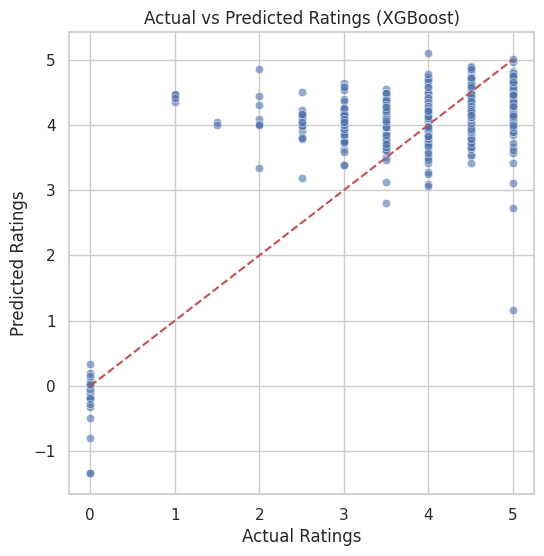

In [34]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings (XGBoost)')
plt.grid(True)
plt.show()


6.3 LightGBM

In [35]:
# Define the model with pipeline
model_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('regressor', lgb.LGBMRegressor(random_state=42, verbose=-1))  # LightGBM model with log messages disabled
])

# Cross-validation on the training set
cv_scores = cross_val_score(model_lgb, X_train, y_train, cv=5, scoring='r2')
print(f"Mean R² score with LightGBM on training set: {cv_scores.mean():.4f}")

# Measure training time
start_time = time.time()  # Start timer

# Train the model on the training set
model_lgb.fit(X_train, y_train)

end_time = time.time()  # End timer

# Make predictions on the test set
y_test_pred = model_lgb.predict(X_test)

# Evaluate performance on the test set
test_r2 = r2_score(y_test, y_test_pred)  # R² score
test_mse = mean_squared_error(y_test, y_test_pred)  # Mean Squared Error

# Calculate total training time
training_time = end_time - start_time

# Print results
print(f"R² score on test set: {test_r2:.4f}")
print(f"Mean Squared Error (MSE) on test set: {test_mse:.4f}")
print(f"Training time: {training_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Mean R² score with LightGBM on training set: 0.7365
R² score on test set: 0.7406
Mean Squared Error (MSE) on test set: 0.2638
Training time: 0.16 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


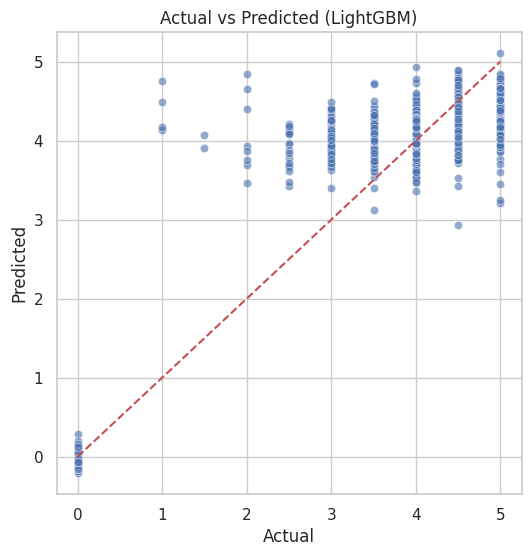

In [36]:
# Visualisasi Prediksi vs Aktual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (LightGBM)')
plt.grid(True)
plt.show()


# **7. Conclusion**

7.1 Model Refinement and Hyperparameter Tuning

In [37]:
# Hyperparameter search space
param_distributions = {
    'regressor__n_estimators': [50, 100, 200, 500],  # Number of trees in the ensemble
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size for weight updates
    'regressor__max_depth': [3, 5, 7, 10, -1],  # Maximum depth of trees (-1 means no limit)
    'regressor__subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for training each tree
    'regressor__colsample_bytree': [0.6, 0.8, 1.0]  # Fraction of features used for each tree
}

# RandomizedSearchCV for hyperparameter tuning
randomized_search = RandomizedSearchCV(
    model_lgb,  # Model to optimize
    param_distributions=param_distributions,  # Search space for hyperparameters
    n_iter=50,
    scoring='r2',
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Running the hyperparameter search
randomized_search.fit(X_train, y_train)

# Best hyperparameter combination and validation score
print("Best hyperparameters:", randomized_search.best_params_)
print("Best R² score on cross-validation:", randomized_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'regressor__subsample': 0.8, 'regressor__n_estimators': 200, 'regressor__max_depth': 10, 'regressor__learning_rate': 0.05, 'regressor__colsample_bytree': 1.0}
Best R² score on cross-validation: 0.7369094799452606


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [39]:
# Define the model with pipeline using the best hyperparameters
model_lgb_optimized = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('regressor', lgb.LGBMRegressor(
        random_state=42,
        verbose=-1,
        subsample=0.6,  # Best hyperparameters from RandomizedSearchCV
        n_estimators=200,
        max_depth=10,
        learning_rate=0.05,
        colsample_bytree=0.8
    ))
])

# Cross-validation on the training set
cv_scores = cross_val_score(model_lgb_optimized, X_train, y_train, cv=5, scoring='r2')
print(f"Mean R² score with optimized LightGBM on training set: {cv_scores.mean():.4f}")

# Measure training time
start_time = time.time()  # Start timer

# Train the model on the training set
model_lgb_optimized.fit(X_train, y_train)

end_time = time.time()  # End timer

# Make predictions on the test set
y_test_pred = model_lgb_optimized.predict(X_test)

# Evaluate performance on the test set
test_r2 = r2_score(y_test, y_test_pred)  # R² score
test_mse = mean_squared_error(y_test, y_test_pred)  # Mean Squared Error

# Calculate total training time
training_time = end_time - start_time

# Print results
print(f"R² score on test set: {test_r2:.4f}")
print(f"Mean Squared Error (MSE) on test set: {test_mse:.4f}")
print(f"Training time: {training_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Mean R² score with optimized LightGBM on training set: 0.7358
R² score on test set: 0.7379
Mean Squared Error (MSE) on test set: 0.2666
Training time: 0.42 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



7.2 Feature Importance Extraction and Visualization

In [40]:
# Extracting feature importance from the trained model
importances = model_lgb_optimized.named_steps['regressor'].feature_importances_

# Transforming the features with the preprocessor
X_train_transformed = model_lgb_optimized.named_steps['preprocessor'].transform(X_train)

# Checking the feature names after transformation
if isinstance(X_train_transformed, csr_matrix):
    feature_names = model_lgb_optimized.named_steps['preprocessor'].get_feature_names_out()
else:
    feature_names = X_train.columns

# Creating a DataFrame to visualize feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sorting features by importance (from highest to lowest)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Displaying the top 10 most important features
print("Top 10 most important features:")
print(importance_df.head(5))

Top 10 most important features:
                     Feature  Importance
1                  num__love        1025
0     num__number_of_reviews         750
2                 num__price         689
3           num__value_price         427
1861       cat__size_no size         115


In [41]:
import joblib

# Simpan model ke file lokal
joblib.dump(model_lgb_optimized, "model_lgb_optimized.pkl")

['model_lgb_optimized.pkl']

In [48]:
!pip install -U huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [49]:
from huggingface_hub import HfApi, upload_file

username = "natasyarev"
repo_name = "lgbm_trinity_minds"

api = HfApi()
api.create_repo(repo_id=f"{username}/{repo_name}", repo_type="model", exist_ok=True)

# Upload file model
upload_file(
    path_or_fileobj="model_lgb_optimized.pkl",  # file model kamu
    path_in_repo="model_lgb_optimized.pkl",     # nama file di repo
    repo_id=f"{username}/{repo_name}",
    repo_type="model"
)


Uploading...:   0%|          | 0.00/574k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/natasyarev/lgbm_trinity_minds/commit/9253b8dbd1e762feb0106ae4ee0fc3de08f91fd6', commit_message='Upload model_lgb_optimized.pkl with huggingface_hub', commit_description='', oid='9253b8dbd1e762feb0106ae4ee0fc3de08f91fd6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/natasyarev/lgbm_trinity_minds', endpoint='https://huggingface.co', repo_type='model', repo_id='natasyarev/lgbm_trinity_minds'), pr_revision=None, pr_num=None)